# Amazonia360+ Report Tool Queries

This notebook contains the queries used to generate the reports for the Amazonia360+ project.

## Table of Contents

[Report Sections](#report-sections)
1. [General Information](#general-information)
2. [Natural Physical Environment](#natural-physical-environment)


## Setup

### Library import

In [44]:
import json
import os
import pprint

import dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
from shapely.geometry import MultiPolygon, Polygon


### Utility functions

In [2]:
#Get token from .env file
dotenv.load_dotenv()


True

In [3]:
def indicator_queries(indicator, geometry, return_geometry='true'):
    """
    Creates a query URL for the ArcGIS service.

    Parameters:
    indicator (str): The dataset name.
    geometry (str): The geometry in JSON format.
    return_geometry (str): Whether to return the geometry. Default is 'true'.

    Returns:
    dict: The data from the query.
    """
    base_url = 'https://services6.arcgis.com/sROlVM0rATIYgC6a/arcgis/rest/services'
    token = os.getenv("ESRI_TOKEN")

    # Create query
    query = (f'{base_url}/{indicator}/FeatureServer/0/query?f=json&geometry={geometry}'
             f'&outFields=*&returnGeometry={return_geometry}&spatialRel=esriSpatialRelIntersects'
             f'&where=FID is not null&geometryType=esriGeometryPolygon&inSR=102100&outSR=4326'
             f'&token={token}')

    # Make request
    r = requests.get(query)
    data = json.loads(r.text)

    return data

In [24]:
def process_geometries(data):
    """
    Processes the geometries from the data.

    Parameters:
    data (dict): The data from the query.

    Returns:
    gdf: The geometries as a GeoDataFrame.
    """
    # Extract attributes and geometry
    attributes = [item['attributes'] for item in data['features']]
    geometry = [MultiPolygon([Polygon(ring) for ring in item['geometry']['rings']]) for item in data['features']]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(attributes, geometry=geometry)

    # Set CRS to ESRI:102100
    #gdf.set_crs(epsg=102100, inplace=True)
    gdf.set_crs(epsg=4326, inplace=True)

    # Reproject to EPSG:4326
    #gdf = gdf.to_crs(epsg=4326)

    return gdf

In [26]:
def get_aoi(geometry):
    """
    Gets the area of interest (AOI) from the geometry.

    Parameters:
    geometry (str): The geometry in JSON format.

    Returns:
    gdf: The AOI as a GeoDataFrame.
    """
    polygon = json.loads(geometry)['rings'][0]
    gdf_poly = gpd.GeoDataFrame([{"name": "polygon"}], geometry=[Polygon(polygon)])
    # Set CRS to ESRI:102100
    gdf_poly.set_crs(epsg=102100, inplace=True)

    # Reproject to EPSG:4326
    gdf_poly = gdf_poly.to_crs(epsg=4326)

    return gdf_poly

In [128]:
def get_raster_stats(geometry, dataset):
    """
    Gets the raster statistics from TiTiler for a given dataset and geometry.
    """
    titiler_endpoint = f'https://api.amazonia360.dev-vizzuality.com/exact_zonal_stats?raster_filename={dataset}&statistics=frac&statistics=unique'
    titiler_token = os.getenv("TITILER_TOKEN")

    g= {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry": gdf_poly.geometry[0].__geo_interface__}]}

    titiler_query = f'{titiler_endpoint}'
    payload = g
    headers = {
        "Authorization": f"Bearer {titiler_token}",
        "Content-Type": "application/json"
    }
    r = requests.post(titiler_query, headers=headers, json=payload)
    d = r.json()
    data = pd.DataFrame(d['features'][0]['properties'])
    data['indicator'] = dataset.strip('.tif')
    data.rename(columns={'frac': 'value', 'unique':'variable'}, inplace=True)
    data = data[['indicator', 'variable', 'value']]

    return data

## Test request (Biomes)

In [25]:
indicator = 'AFP_Biomas' # Add dataset name
geometry='{"rings":[[[-7616190.8247354245,-1708924.3563412805],[-7506522.798403298,-1431438.834409093],[-6936015.928539964,-1415463.4954974954],[-5951163.037599873,-1486282.4022036926],[-5381076.571392109,-1617142.5946278796],[-5326328.5498828655,-1716892.916540008],[-5584704.814743764,-1788151.3361588446],[-5762478.233277965,-1905443.9560624165],[-6225228.0025162995,-1888990.8857240365],[-6398969.367808459,-1969784.8246214464],[-6501127.45611157,-1784864.5439425828],[-6807009.334051693,-1826713.8169287057],[-6780619.450036243,-2031125.5398202841],[-7149867.624424759,-2204293.6274003047],[-7616190.8247354245,-1708924.3563412805]]]}'
return_geometry='true'
data = indicator_queries(indicator, geometry, return_geometry)

In [28]:
gdf_poly = get_aoi(geometry)
gdf_poly

,name,geometry
0,polygon,"POLYGON ((-68.41741 -15.17108, -67.43224 -12.7..."


In [ ]:
gdf = process_geometries(data)
gdf

,FID,BIOME,BIOMADES,Shape__Area,Shape__Length,geometry
0,1,1,Tropical and Subtropical Moist Broadleaf Forests,6.740088e+12,6.596722e+07,"MULTIPOLYGON (((-62.16851 9.93850, -62.18296 9..."
1,2,2,Tropical and Subtropical Dry Broadleaf Forests,2.687076e+11,1.399060e+07,"MULTIPOLYGON (((-73.95417 3.35417, -73.95083 3..."
2,3,7,"Tropical and Subtropical Grasslands, Savannas ...",1.337588e+12,4.513371e+07,"MULTIPOLYGON (((-62.20739 8.64443, -62.24595 8..."
3,4,9,Flooded Grasslands and Savannas,6.400192e+10,4.039980e+06,"MULTIPOLYGON (((-62.07857 9.87582, -62.07703 9..."
4,5,10,Montane Grasslands and Shrublands,1.260113e+11,2.159517e+07,"MULTIPOLYGON (((-74.77648 2.94274, -74.77165 2..."


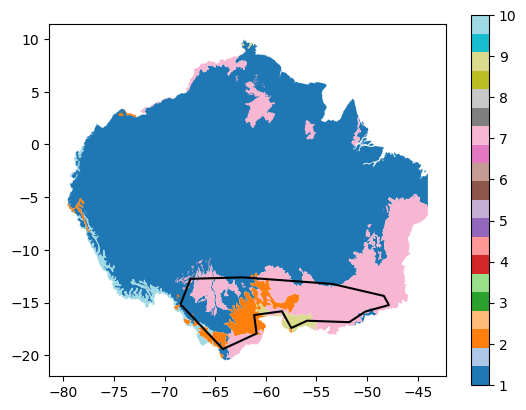

In [8]:
fig, ax = plt.subplots()

# Plot each item of gdf with a different fill color
gdf.plot(ax=ax, column='BIOME', cmap='tab20', legend=True)

# Plot just the outline of gdf_poly
gdf_poly.boundary.plot(ax=ax, color='black')

plt.show()

In [63]:
# Perform intersection
intersection = gpd.overlay(gdf, gdf_poly, how='intersection')

# Calculate area of the intersected geometries
intersection['intersected_area'] = intersection['geometry'].area

# Calculate the proportion of the area of each resulting geometry
intersection['area_proportion'] = intersection['intersected_area'] / intersection['intersected_area'].sum() * 100

intersection

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_2798/1082837670.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,FID,BIOME,BIOMADES,Shape__Area,Shape__Length,name,geometry,intersected_area,area_proportion
0,1,1,Tropical and Subtropical Moist Broadleaf Forests,6.740088e+12,6.596722e+07,polygon,"MULTIPOLYGON (((-49.04063 -15.00827, -49.05323...",18.568144,23.715397
1,2,2,Tropical and Subtropical Dry Broadleaf Forests,2.687076e+11,1.399060e+07,polygon,"MULTIPOLYGON (((-59.68644 -13.22280, -59.67268...",15.970118,20.397176
2,3,7,"Tropical and Subtropical Grasslands, Savannas ...",1.337588e+12,4.513371e+07,polygon,"MULTIPOLYGON (((-49.39565 -15.63417, -49.40267...",40.580855,51.830227
3,4,9,Flooded Grasslands and Savannas,6.400192e+10,4.039980e+06,polygon,"MULTIPOLYGON (((-55.34078 -16.73221, -55.27580...",2.817134,3.598069
4,5,10,Montane Grasslands and Shrublands,1.260113e+11,2.159517e+07,polygon,"POLYGON ((-66.63850 -16.97374, -66.63928 -16.9...",0.359480,0.459131


<a id='report-sections'></a>
## Report Sections

<a id='general-information'></a>
### 1. General Information

**Feature services**  
Capitals: `AFP_CAPITALES_ADMIN`  
Protected areas: `AFP_Areas_protegidas`  
Indigenous lands: `AFP_Tierras_indigenas`  
Hydrographic basins: `AFP_Grandes_cuencas_hidrograficas`  

**Raster stats**  
Population: `population.tif`


In [14]:
geometry='{"rings":[[[-7616190.8247354245,-1708924.3563412805],[-7506522.798403298,-1431438.834409093],[-6936015.928539964,-1415463.4954974954],[-5951163.037599873,-1486282.4022036926],[-5381076.571392109,-1617142.5946278796],[-5326328.5498828655,-1716892.916540008],[-5584704.814743764,-1788151.3361588446],[-5762478.233277965,-1905443.9560624165],[-6225228.0025162995,-1888990.8857240365],[-6398969.367808459,-1969784.8246214464],[-6501127.45611157,-1784864.5439425828],[-6807009.334051693,-1826713.8169287057],[-6780619.450036243,-2031125.5398202841],[-7149867.624424759,-2204293.6274003047],[-7616190.8247354245,-1708924.3563412805]]]}'


### 1.1 Capitals

In [19]:
def get_capitals(geometry):
    """
    Get the capitals within a geometry.
    """
    indicator = 'AFP_CAPITALES_ADMIN'
    return_geometry = 'false'
    data = indicator_queries(indicator, geometry, return_geometry)

    return data

In [21]:
get_capitals(geometry)

{'objectIdFieldName': 'FID',
 'uniqueIdField': {'name': 'FID', 'isSystemMaintained': True},
 'globalIdFieldName': '',
 'geometryType': 'esriGeometryPoint',
 'spatialReference': {'wkid': 4326, 'latestWkid': 4326},
 'fields': [{'name': 'FID',
   'type': 'esriFieldTypeOID',
   'alias': 'FID',
   'sqlType': 'sqlTypeInteger',
   'domain': None,
   'defaultValue': None},
  {'name': 'ID_0',
   'type': 'esriFieldTypeInteger',
   'alias': 'ID_0',
   'sqlType': 'sqlTypeInteger',
   'domain': None,
   'defaultValue': None},
  {'name': 'ISO',
   'type': 'esriFieldTypeString',
   'alias': 'ISO',
   'sqlType': 'sqlTypeNVarchar',
   'length': 3,
   'domain': None,
   'defaultValue': None},
  {'name': 'NAME_0',
   'type': 'esriFieldTypeString',
   'alias': 'NAME_0',
   'sqlType': 'sqlTypeNVarchar',
   'length': 75,
   'domain': None,
   'defaultValue': None},
  {'name': 'NAME_1',
   'type': 'esriFieldTypeString',
   'alias': 'NAME_1',
   'sqlType': 'sqlTypeNVarchar',
   'length': 75,
   'domain': None

### 1.2 Protected Areas

In [50]:
def get_pa(geometry):
    """
    Get the protected areas within a geometry.
    """
    indicator = 'AFP_AREAS_PROTEGIDAS'
    return_geometry = 'true'
    qry = indicator_queries(indicator, geometry, return_geometry)
    dt = process_geometries(qry)
    aoi = get_aoi(geometry)
    aoi_area = aoi['geometry'].area[0]
    intersection = gpd.overlay(dt, aoi, how='intersection')
    intersection['intersected_area'] = intersection['geometry'].area
    #Calculate proportion of each intersection relative to area of aoi:
    intersection['area_proportion'] = intersection.apply(lambda x: x['intersected_area'] / aoi_area * 100, axis=1)

    # Create a DataFrame with the results (count and proportion)
    data = pd.DataFrame({'indicator': 'Protected areas',
                         'variable': ['count', 'propotion'],
                         'value': [len(intersection), round(intersection['area_proportion'].sum(),2)]})

    return data

In [51]:
get_pa(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/958085630.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_area = aoi['geometry'].area[0]
/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/958085630.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,indicator,variable,value
0,Protected areas,count,158.00
1,Protected areas,propotion,24.69


### 1.3 Indigenous Lands

In [136]:
def get_indigenous(geometry):
    """
    Get the indigenous lands areas within a geometry.
    """
    indicator = 'AFP_Tierras_indigenas'
    return_geometry = 'true'
    qry = indicator_queries(indicator, geometry, return_geometry)
    dt = process_geometries(qry)
    aoi = get_aoi(geometry)
    aoi_area = aoi['geometry'].area[0]
    intersection = gpd.overlay(dt, aoi, how='intersection')
    intersection['intersected_area'] = intersection['geometry'].area
    #Calculate proportion of each intersection relative to area of aoi:
    intersection['area_proportion'] = intersection.apply(lambda x: x['intersected_area'] / aoi_area * 100, axis=1)

    # Create a DataFrame with the results (count and proportion)
    data = pd.DataFrame({'indicator': 'Indigenous lands',
                         'variable': ['count', 'propotion'],
                         'value': [len(intersection), round(intersection['area_proportion'].sum(),2)]})

    return data

In [137]:
get_indigenous(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/2463362375.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_area = aoi['geometry'].area[0]
/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/2463362375.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,indicator,variable,value
0,Indigenous lands,count,115.00
1,Indigenous lands,propotion,18.29


### 1.4 Hydrographic Basins  
`AFP_Grandes_cuencas_hidrograficas`

In [ ]:
def get_basins(geometry):
    """
    Get the indigenous lands areas within a geometry.
    """
    indicator = 'AFP_Grandes_cuencas_hidrograficas'
    return_geometry = 'true'
    qry = indicator_queries(indicator, geometry, return_geometry)
    dt = process_geometries(qry)
    aoi = get_aoi(geometry)
    #aoi_area = aoi['geometry'].area[0]
    intersection = gpd.overlay(dt, aoi, how='intersection')
    intersection['intersected_area'] = intersection['geometry'].area
    #Calculate proportion of each intersection relative to area of aoi:
    intersection['area_proportion'] = intersection['intersected_area'] / intersection['intersected_area'].sum() * 100
    intersection['indicator'] = 'Basins'
    intersection.rename(columns={'MAJ_NAME': 'variable', 'area_proportion': 'value'}, inplace=True)

    data = intersection[['indicator', 'variable', 'value']]

    return data

In [138]:
get_basins(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/754838227.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,indicator,variable,value
0,Basins,Amazonas,69.052870
1,Basins,La Plata,13.978869
2,Basins,Tocantins,16.968262


### 1.5 Population

In [105]:
d = get_raster_stats(geometry, 'population.tif')
d

,frac,unique
0,0.000004,586.0
1,0.000004,604.0
2,0.000004,597.0
3,0.000004,549.0
4,0.000004,589.0
...,...,...
708,0.000023,512.0
709,0.000011,494.0
710,0.000057,416.0
711,0.000019,483.0


<a id='natural-physical-environment'></a>
### 2. Natural Physical Environment

**Feature services**  
Climatic zones: `AFP_Tipos_climaticos_KOEPEN`  
Biomes: `AFP_Biomas`  

**Raster stats**  
Elevation: `elevation_ranges.tif`  
Land cover: `landcover.tif`

### 2.1 Climatic Zones

In [116]:
def get_climate(geometry):
    """
    Get the Koepen climatic zones within a geometry.
    """
    indicator = 'AFP_Tipos_climaticos_KOEPEN'
    return_geometry = 'true'
    qry = indicator_queries(indicator, geometry, return_geometry)
    dt = process_geometries(qry)
    aoi = get_aoi(geometry)
    intersection = gpd.overlay(dt, aoi, how='intersection')
    intersection['intersected_area'] = intersection['geometry'].area
    #Calculate proportion of each intersection relative to area of aoi:
    intersection['area_proportion'] = intersection['intersected_area'] / intersection['intersected_area'].sum() * 100
    intersection['indicator'] = 'Climate'
    intersection.rename(columns={'Field3': 'variable', 'area_proportion': 'value'}, inplace=True)

    data = intersection[['indicator', 'variable', 'value']]

    return data

In [113]:
get_climate(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/392157718.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,indicator,variable,value
0,Climate,"Tropical, rainforest",5.770572
1,Climate,"Temperate, dry summer, warm summer",2.340885
2,Climate,"Temperate, no dry season, warm summer",0.810423
3,Climate,"Tropical, monsoon",10.545213
4,Climate,"Tropical, savannah",78.179286
5,Climate,"Arid, steppe, cold",0.912965
6,Climate,"Arid, steppe, hot",1.180619
7,Climate,"Polar, tundra or frost",0.260038


### 2.2 Biomes

In [119]:
def get_biomes(geometry):
    """
    Get the biomes within a geometry.
    """
    indicator = 'AFP_Biomas'
    return_geometry = 'true'
    qry = indicator_queries(indicator, geometry, return_geometry)
    dt = process_geometries(qry)
    aoi = get_aoi(geometry)
    intersection = gpd.overlay(dt, aoi, how='intersection')
    intersection['intersected_area'] = intersection['geometry'].area
    #Calculate proportion of each intersection relative to area of aoi:
    intersection['area_proportion'] = intersection['intersected_area'] / intersection['intersected_area'].sum() * 100
    intersection['indicator'] = 'Climate'
    intersection.rename(columns={'BIOMADES': 'variable', 'area_proportion': 'value'}, inplace=True)

    data = intersection[['indicator', 'variable', 'value']]

    return data

In [120]:
get_biomes(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/3546552016.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area


,indicator,variable,value
0,Climate,Tropical and Subtropical Moist Broadleaf Forests,23.715397
1,Climate,Tropical and Subtropical Dry Broadleaf Forests,20.397176
2,Climate,"Tropical and Subtropical Grasslands, Savannas ...",51.830227
3,Climate,Flooded Grasslands and Savannas,3.598069
4,Climate,Montane Grasslands and Shrublands,0.459131


In [129]:
get_raster_stats(geometry, 'landcover.tif')

,indicator,variable,value
0,landcover,60.0,0.001108
1,landcover,50.0,0.001522
2,landcover,40.0,0.109726
3,landcover,20.0,0.046032
4,landcover,80.0,0.007771
5,landcover,90.0,0.022841
6,landcover,30.0,0.298051
7,landcover,10.0,0.512949


In [131]:
get_raster_stats(geometry, 'elevation_ranges.tif')

,indicator,variable,value
0,elevation_ranges,8.0,0.002330
1,elevation_ranges,3.0,0.004227
2,elevation_ranges,7.0,0.061869
3,elevation_ranges,6.0,0.174254
4,elevation_ranges,5.0,0.362027
5,elevation_ranges,4.0,0.395292


## Get all data

In [139]:
def get_aoi_data(geometry):
    """
    Get all the data for the area of interest (AOI).
    """
    data = []
    data.append(get_pa(geometry))
    data.append(get_indigenous(geometry))
    data.append(get_basins(geometry))
    data.append(get_climate(geometry))
    data.append(get_biomes(geometry))
    #data.append(get_raster_stats(geometry, 'population.tif'))
    data.append(get_raster_stats(geometry, 'landcover.tif'))
    data.append(get_raster_stats(geometry, 'elevation_ranges.tif'))

    data = pd.concat(data)

    return data

In [140]:
get_aoi_data(geometry)

/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/958085630.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_area = aoi['geometry'].area[0]
/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/958085630.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersected_area'] = intersection['geometry'].area
/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/2463362375.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_area = aoi['geometry'].area[0]
/var/folders/wf/_wlxc6cn5js4hh3j7j6x28f80000gn/T/ipykernel_6905/24633623

,indicator,variable,value
0,Protected areas,count,158.000000
1,Protected areas,propotion,24.690000
0,Indigenous lands,count,115.000000
1,Indigenous lands,propotion,18.290000
0,Basins,Amazonas,69.052870
1,Basins,La Plata,13.978869
2,Basins,Tocantins,16.968262
0,Climate,"Tropical, rainforest",5.770572
1,Climate,"Temperate, dry summer, warm summer",2.340885
2,Climate,"Temperate, no dry season, warm summer",0.810423


In [125]:
#TO DO:
# Get category values for rasters
# Calculate total population
# Filter just top categories on each indicator?